#Przegląd

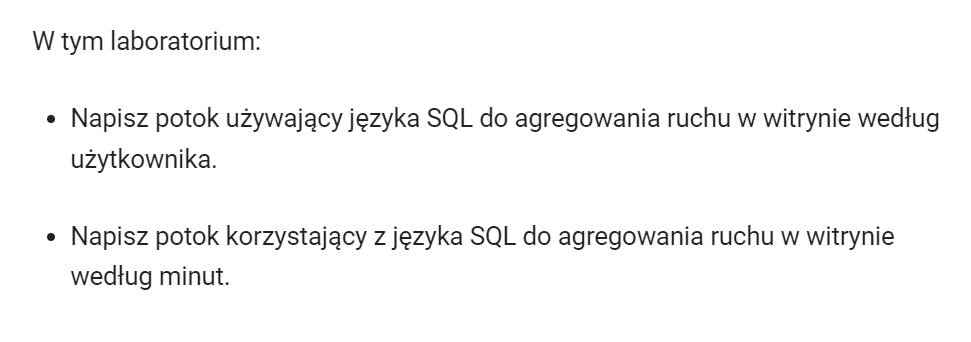

#Konfiguracja środowiska programistycznego opartego na notatniku Jupyter

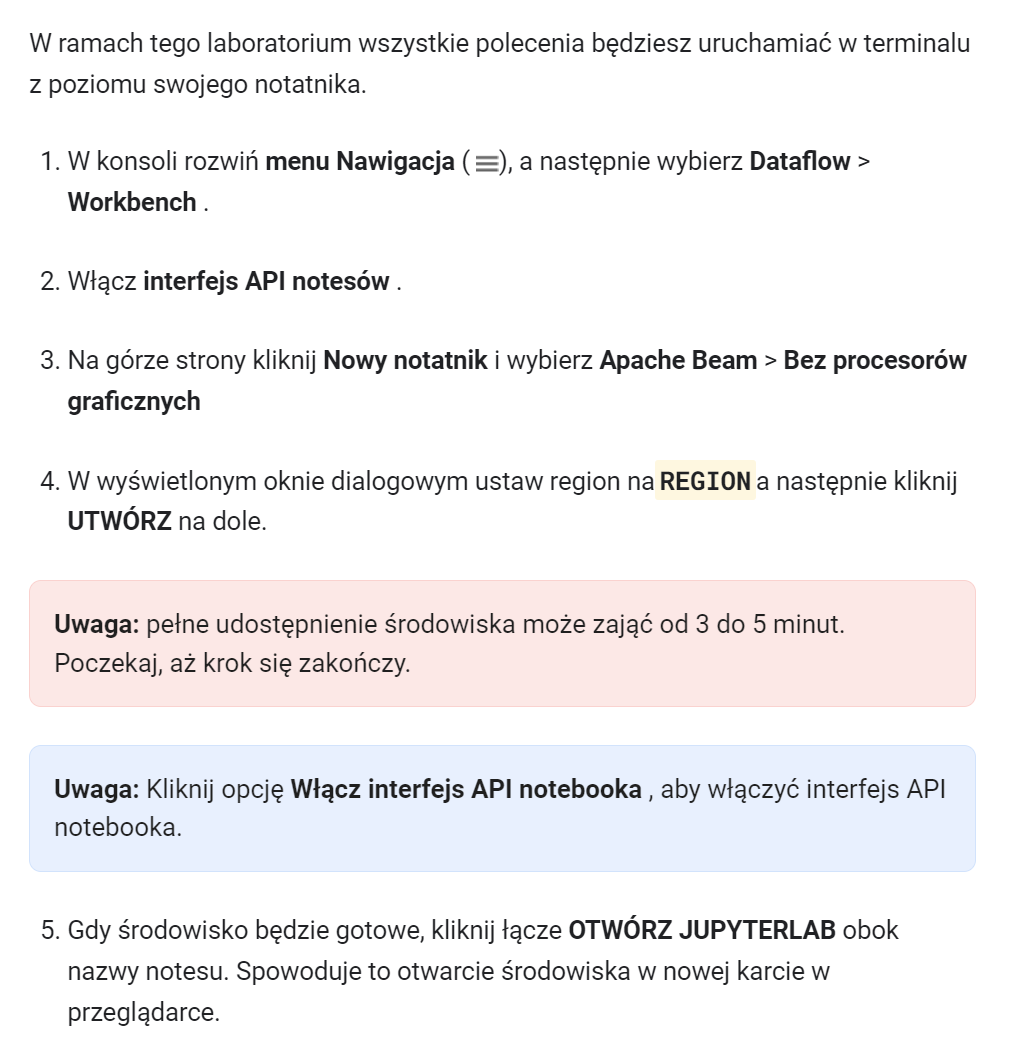

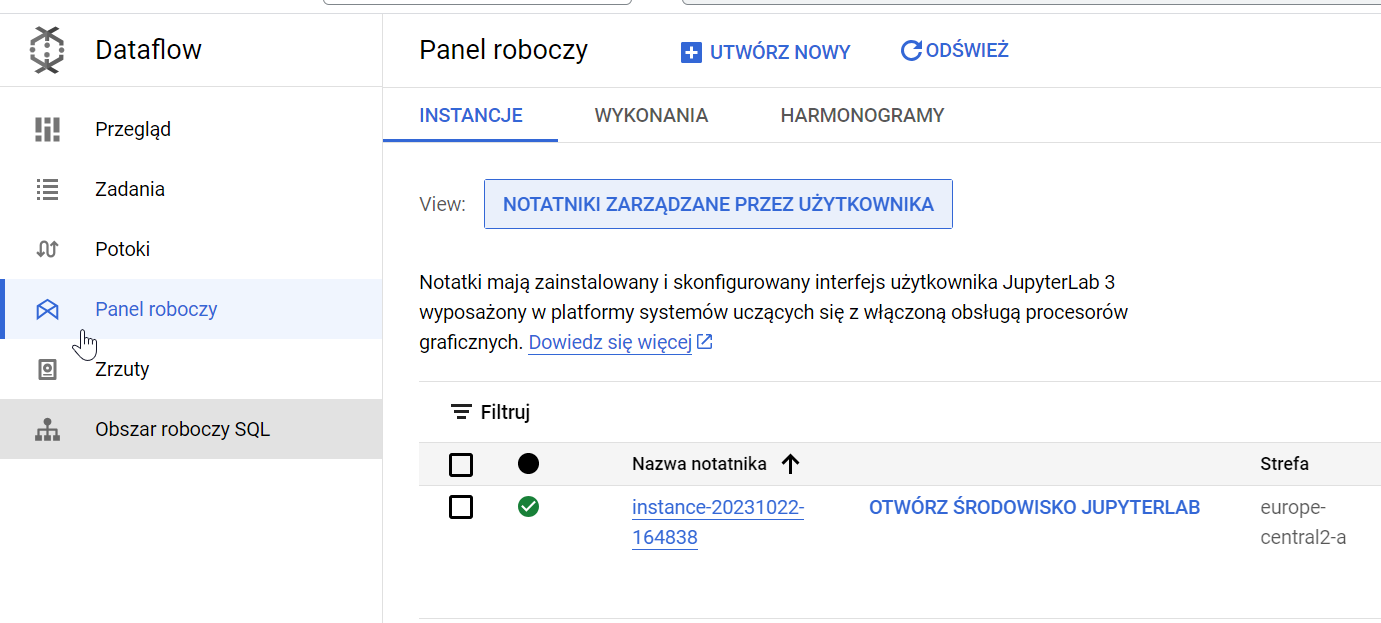

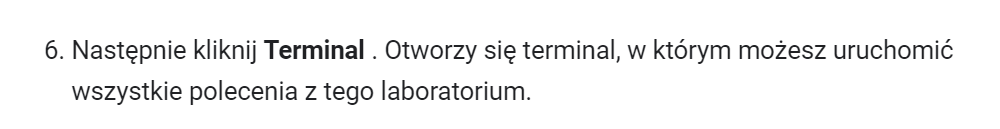

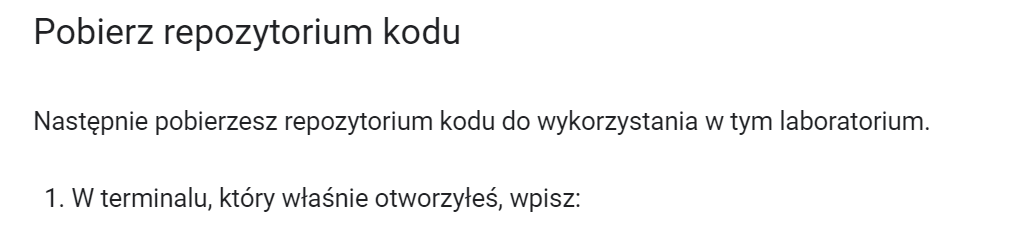

In [ ]:
git clone https://github.com/GoogleCloudPlatform/training-data-analyst

In [ ]:
cd /home/jupyter/training-data-analyst/quests/dataflow_python/

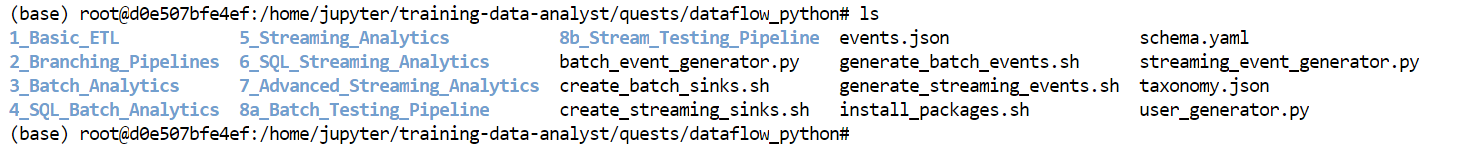

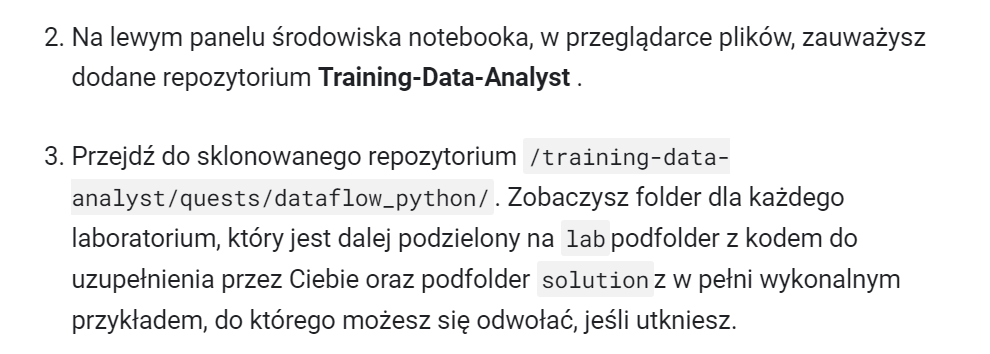

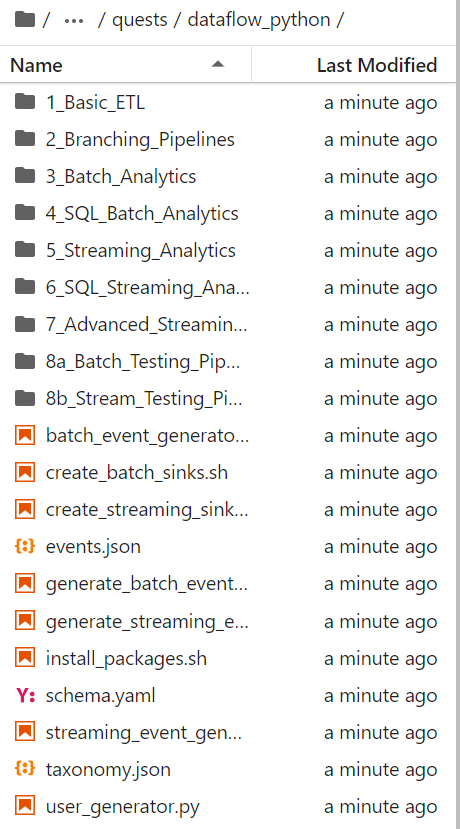

#Część 1: Agregowanie ruchu w witrynie według użytkownika za pomocą SQL

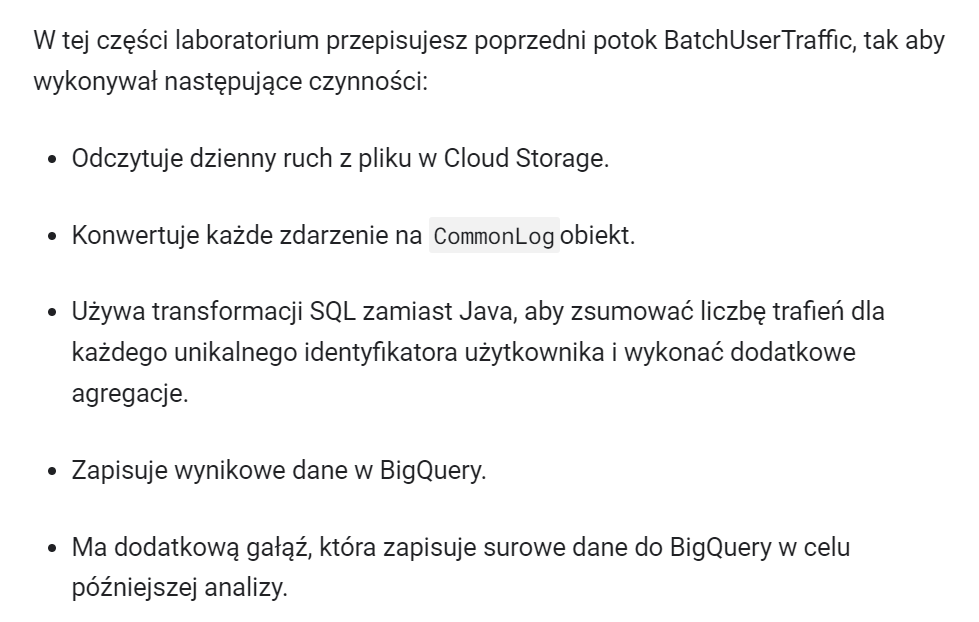

##Zadanie 1. Wygeneruj dane syntetyczne

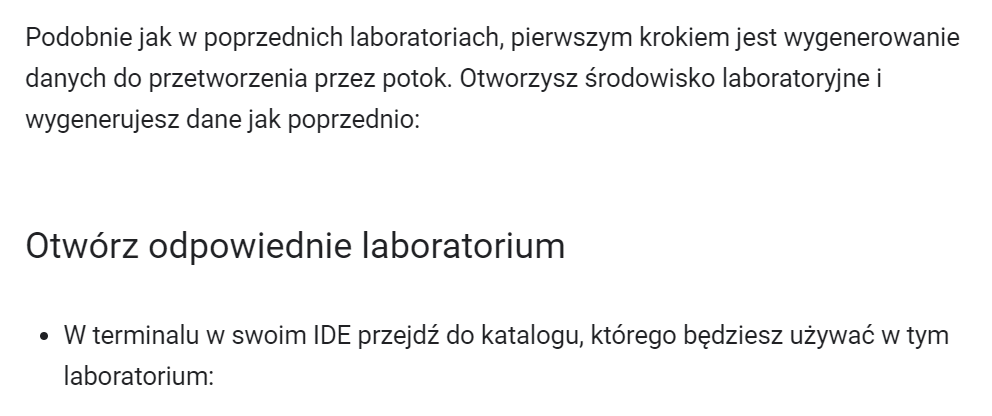

In [ ]:
# Change directory into the lab
cd 4_SQL_Batch_Analytics/lab

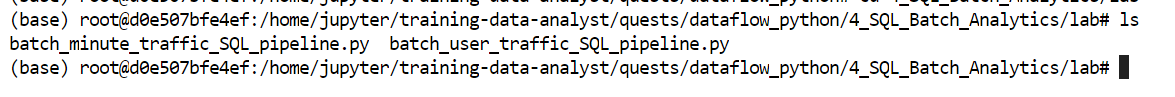

In [ ]:
# pwd to bieżący katalog
export BASE_DIR=$(pwd)

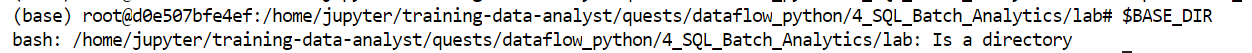

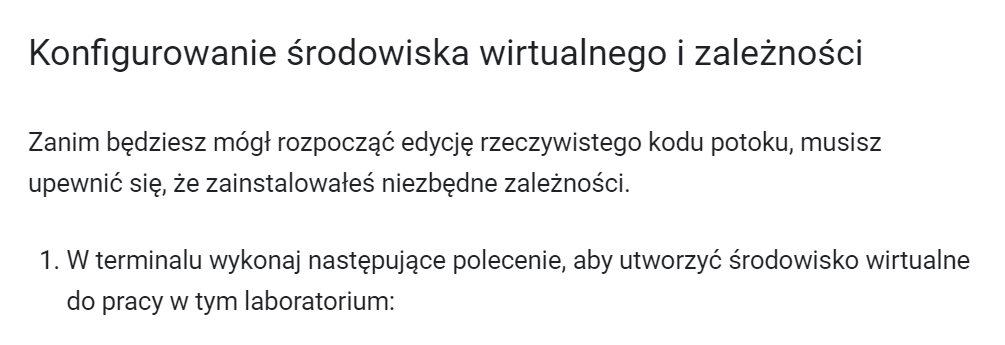

In [ ]:
sudo apt-get update && sudo apt-get install -y python3-venv

In [ ]:
# Create and activate virtual environment
python3 -m venv df-env

In [ ]:
source df-env/bin/activate

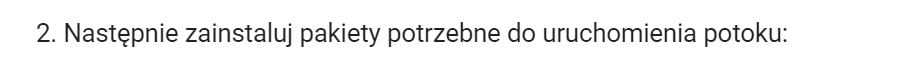

In [ ]:
python3 -m pip install -q --upgrade pip setuptools wheel

In [ ]:
python3 -m pip install apache-beam[gcp]

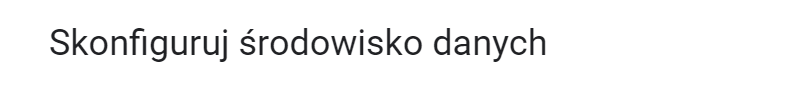

In [ ]:
# Create GCS buckets and BQ dataset
cd $BASE_DIR/../..

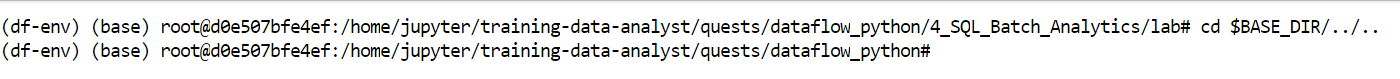

In [ ]:
source create_batch_sinks.sh

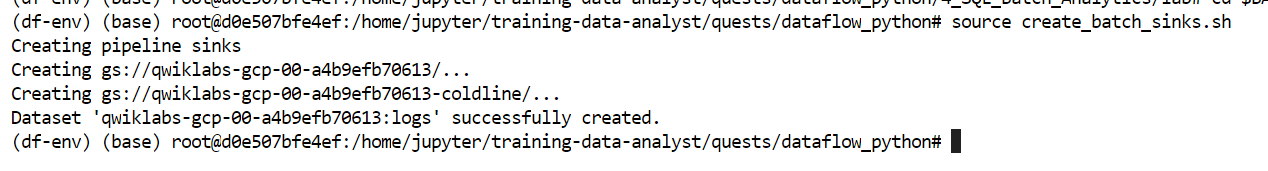

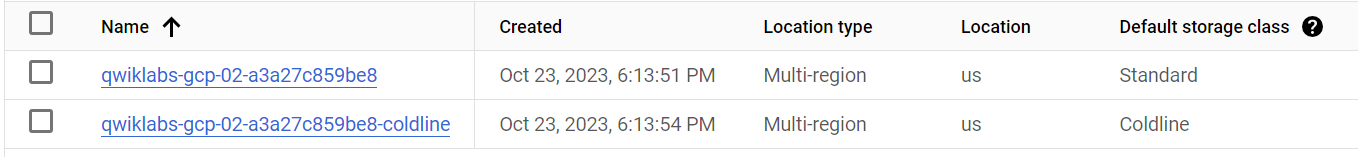

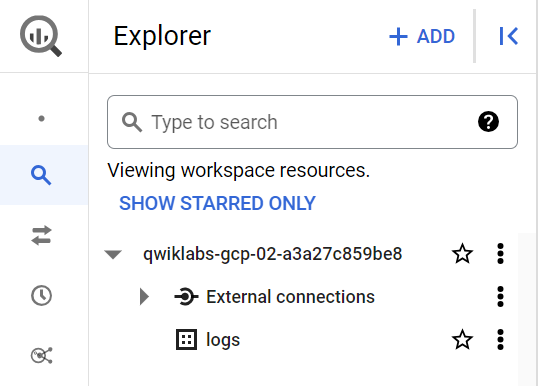

In [ ]:
# Generate event dataflow
source generate_batch_events.sh

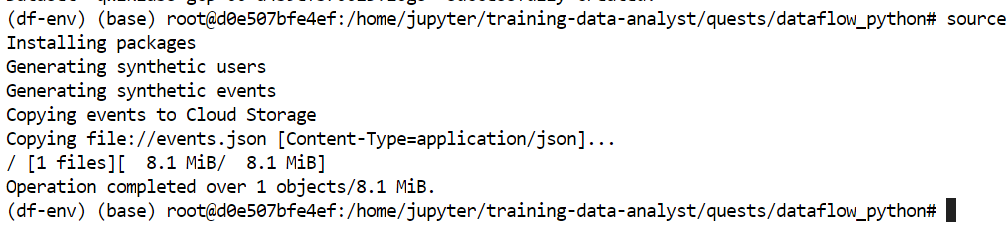

In [ ]:
{"ip": "64.139.110.121", "user_id": "3550555373202755476", "lat": 48.3613, "lng": -119.5834, "timestamp": "2023-10-23T16:14:10.013497Z", "http_request": "\"GET bacteria.html HTTP/1.0\"", "http_response": 200, "num_bytes": 456, "user_agent": "Mozilla/5.0 (Macintosh; PPC Mac OS X 10_7_9) AppleWebKit/531.1 (KHTML"}
{"ip": "64.139.110.121", "user_id": "3550555373202755476", "lat": 48.3613, "lng": -119.5834, "timestamp": "2023-10-23T16:14:17.039055Z", "http_request": "\"GET bacteria.html HTTP/1.0\"", "http_response": 200, "num_bytes": 303, "user_agent": "Mozilla/5.0 (Macintosh; PPC Mac OS X 10_7_9) AppleWebKit/531.1 (KHTML"}
{"ip": "64.139.110.121", "user_id": "3550555373202755476", "lat": 48.3613, "lng": -119.5834, "timestamp": "2023-10-23T16:14:21.092315Z", "http_request": "\"GET bacteria.html HTTP/1.0\"", "http_response": 200, "num_bytes": 137, "user_agent": "Mozilla/5.0 (Macintosh; PPC Mac OS X 10_7_9) AppleWebKit/531.1 (KHTML"}

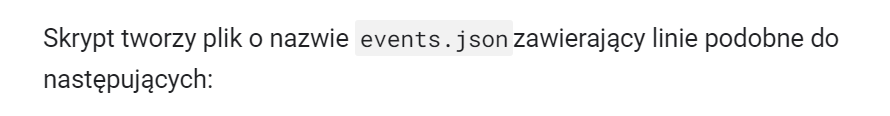

In [ ]:
# Change to the directory containing the practice version of the code
cd $BASE_DIR

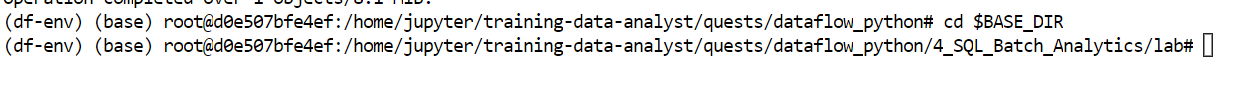

create_batch_sinks.sh

In [ ]:
#!/bin/#!/usr/bin/env bash
echo "Creating pipeline sinks"

PROJECT_ID=$(gcloud config get-value project)

# GCS buckets
#TODO: Add try/catch for the first bucket since qwiklabs
gsutil mb -l US gs://$PROJECT_ID
gsutil mb -l US -c "COLDLINE" gs://$PROJECT_ID-coldline

# BiqQuery Dataset
bq mk --location=US logs

generate_batch_events.sh

In [ ]:
#!/bin/#!/usr/bin/env bash
echo "Installing packages"
# Install modules
sh ./install_packages.sh

echo "Generating synthetic users"
# Generate 2 fake web site users
python3 user_generator.py --n=10

echo "Generating synthetic events"
rm *.out 2> /dev/null
# Generate 10 events
python3 batch_event_generator.py --num_e=1000

echo "Copying events to Cloud Storage"
# Set BUCKET to the non-coldline Google Cloud Storage bucket
export BUCKET=gs://$(gcloud config get-value project)/
# Copy events.json into the bucket
gsutil cp events.json ${BUCKET}

Ta linijka wskazuje, że skrypt należy uruchomić za pomocą interpretera bash.

```
#!/bin/#!/usr/bin/env bash
```
Ta linijka wyświetla na konsoli komunikat "Installing packages".
```
echo "Installing packages"
```
Ta linijka uruchamia skrypt install_packages.sh, który instaluje niezbędne pakiety.
```
sh ./install_packages.sh
```
Ta linijka uruchamia skrypt user_generator.py, który generuje 10 syntetycznych użytkowników.

```
python3 user_generator.py --n=10
```
Ta linijka usuwa wszystkie pliki *.out, jeśli istnieją.
```
rm *.out 2> /dev/null
```
Ta linijka uruchamia skrypt batch_event_generator.py, który generuje 1000 syntetycznych zdarzeń.
```
python3 batch_event_generator.py --num_e=1000
```
Ta linijka ustawia zmienną środowiskową BUCKET na wartość non-coldline Google Cloud Storage bucket.
```
export BUCKET=gs://$(gcloud config get-value project)/
```
Ta linijka kopiuje plik events.json do bucketu Cloud Storage określonego zmienną środowiskową BUCKET.
```
gsutil cp events.json ${BUCKET}
```

install_packages.sh

In [ ]:
#/bin/sh
pip3 install -q anytree
pip3 install -q --upgrade google-cloud-pubsub
pip3 install -q faker
pip3 install -q --upgrade geocoder

user_generator.py



In [ ]:
# Generates random users for a website

import argparse
from faker import Faker
import geocoder
from random import choice

parser = argparse.ArgumentParser(__file__, description="Web Server Data Generator")
parser.add_argument("--num_users", "-u", type=int, dest="num_users",
                    help="The number of users to create", default=100)

args = parser.parse_args()
num_users = int(args.num_users)

faker = Faker()
# A list of functions for generating user agent strings for various browsers
ualist = [faker.firefox, faker.chrome, faker.safari, faker.internet_explorer, faker.opera]

sensitive_fields = ['lat', 'lng', 'ip', 'user_agent']

def generate_user():
    """
    Returns a randomly generate dictionary representing a user, where each user is described by
    a user agent string, an ID, a latlng, an IP, an age_bracket, whether they've oped into marketing
    and the
    :return:
    """
    user = {}
    user['lat'] = ""
    user['lng'] = ""
    while user['lat'] == "" or user['lng'] == "":
        user['ip'] = faker.ipv4()
        g = geocoder.ip(user['ip'])
        latlng = list(map(str, g.latlng))
        if len(latlng) == 2:
            user['lat'] = latlng[0]
            user['lng'] = latlng[1]
    user['user_agent'] = choice(ualist)()
    user['age_bracket'] = choice(['18-25', '26-40', '41-55', '55+'])
    user['opted_into_marketing'] = choice([True, False])
    user['id'] = hash(str(user['ip']) + str(user['lat'] + str(user['lng'])))
    return user

def write_csvs(users):
    """
    Writes two .csv files, one for ingestiong by an event generator, the other formatted to be uploaded to BigQuery
    :param users:
    :return:
    """
    with open("users.csv", 'w') as event_out, open("users_bq.txt", 'w') as bq_out:
            cols = list(users[0].keys())
            cols.sort()
            bq_cols = cols.copy()
            [bq_cols.remove(s) for s in sensitive_fields]
            event_out.write(",".join(cols) + '\n')
            for user in users:
                event_vals = [str(user[key]) for key in cols]
                event_out.write(",".join(event_vals) + '\n')
                bq_vals = [str(user[key]) for key in bq_cols]
                bq_out.write(",".join(bq_vals) + '\n')

if __name__ == '__main__':
    users = [generate_user() for i in range(num_users)]
    write_csvs(users)

batch_event_generator.py

In [ ]:
# This program reads a file representing web server logs in common log format and streams them into a PubSub topic
# with lag characteristics as determined by command-line arguments

import argparse
import time, glob
from datetime import datetime, timezone, timedelta
import random
from anytree.importer import DictImporter
import json
from multiprocessing import Process, Value, Lock
from copy import deepcopy
import os
from signal import SIGKILL

parser = argparse.ArgumentParser(__file__, description="event_generator")
parser.add_argument("--taxonomy", "-x", dest="taxonomy_fp",
                    help="A .json file representing a taxonomy of web resources",
                    default="taxonomy.json")
parser.add_argument("--users_fp", "-u", dest="users_fp",
                    help="A .csv file of users",
                    default="users.csv")
parser.add_argument("--num_e", "-e", dest="max_num_events", type=int,
                    help="The maximum number of events to generate before " \
                    " stopping. Defaults to None, which means run" \
                    " indefinitely", default=1000)
parser.add_argument("--off_to_on", "-off", dest="off_to_on_prob", type=float,
                    help="A float representing the probability that a user who is offline will come online",
                    default=.25)
parser.add_argument("--on_to_off", "-on", dest="on_to_off_prob", type=float,
                    help="A float representing the probability that a user who is online will go offline",
                    default=.1)

page_read_secs = 5
args = parser.parse_args()
taxonomy_fp = args.taxonomy_fp
users_fp = args.users_fp
max_num_events = args.max_num_events
online_to_offline_probability = args.on_to_off_prob
offline_to_online_probability = args.off_to_on_prob

min_file_size_bytes = 100
max_file_size_bytes = 500
verbs = ["GET"]
responses = [200]


log_fields = ["ip", "user_id", "lat", "lng", "timestamp", "http_request", "http_response", "num_bytes", "user_agent"]

def extract_resources(taxonomy_filepath):
    """
    Reads a .json representing a taxonomy and returns
    a data structure representing their hierarchical relationship
    :param taxonomy_file: a string representing a path to a .json file
    :return: Node representing root of taxonomic tree
    """

    try:
        with open(taxonomy_filepath, 'r') as fp:
            json_str = fp.read()
            json_data = json.loads(json_str)
            root = DictImporter().import_(json_data)
    finally:
        fp.close()

    return root


def read_users(users_fp):
    """
    Reads a .csv from @user_fp representing users into a list of dictionaries,
    each elt of which represents a user
    :param user_fp: a .csv file where each line represents a user
    :return: a list of dictionaries
    """
    users = []
    with open(users_fp, 'r') as fp:
        fields = fp.readline().rstrip().split(",")
        for line in fp:
            user = dict(zip(fields, line.rstrip().split(",")))
            users.append(user)
    return users

def publish_burst(burst, num_events_counter, fp):
    """
    Publishes and prints each event
    :param burst: a list of dictionaries, each representing an event
    :param num_events_counter: an instance of Value shared by all processes to
    track the number of published events
    :param publisher: a PubSub publisher
    :param topic_path: a topic path for PubSub
    :return:
    """
    for event_dict in burst:
        json_str = json.dumps(event_dict)
        num_events_counter.value += 1
        fp.write(json_str + '\n')

def create_user_process(user, root, num_events_counter):
    """
    Code for continuously-running process representing a user publishing
    events to pubsub
    :param user: a dictionary representing characteristics of the user
    :param root: an instance of AnyNode representing the home page of a website
    :param num_events_counter: a variable shared among all processes used to track the number of events published
    :return:
    """

    user['page'] = root
    user['is_online'] = True
    user['offline_events'] = []
    user['time'] = datetime.now()
    while True:
        fp = open(str(os.getpid()) + ".out", "a")
        read_time_secs = random.uniform(0, page_read_secs * 2)
        user['time'] += timedelta(seconds=read_time_secs)
        prob = random.random()
        event = generate_event(user)
        if user['is_online']:
            if prob < online_to_offline_probability:
                user['is_online'] = False
                user['offline_events'] = [event]
            else:
                publish_burst([event], num_events_counter, fp)
        else:
            user['offline_events'].append(event)
            if prob < offline_to_online_probability:
                user['is_online'] = True
                publish_burst(user['offline_events'], num_events_counter, fp)
                user['offline_events'] = []
        fp.close()

def generate_event(user):
    """
    Returns a dictionary representing an event
    :param user:
    :return:
    """
    user['page'] = get_next_page(user)
    uri = str(user['page'].name)
    event_time = user['time']
    current_time_str = event_time.strftime('%Y-%m-%dT%H:%M:%S.%fZ')
    file_size_bytes = random.choice(range(min_file_size_bytes, max_file_size_bytes))
    http_request = "\"{} {} HTTP/1.0\"".format(random.choice(verbs), uri)
    http_response = random.choice(responses)
    event_values = [user['ip'], user['id'], float(user['lat']), float(user['lng']), current_time_str, http_request,
                    http_response, file_size_bytes, user['user_agent']]

    return dict(zip(log_fields, event_values))

def get_next_page(user):
    """
    Consults the user's representation of the web site taxonomy to determine the next page that they visit
    :param user:
    :return:
    """
    possible_next_pages = [user['page']]
    if not user['page'].is_leaf:
        possible_next_pages += list(user['page'].children)
    if (user['page'].parent != None):
        possible_next_pages += [user['page'].parent]
    next_page = random.choice(possible_next_pages)
    return next_page


if __name__ == '__main__':
    num_events_counter = Value('i', 0)
    users = read_users(users_fp)
    root = extract_resources(taxonomy_fp)
    processes = [Process(target=create_user_process, args=(deepcopy(user), deepcopy(root), num_events_counter))
                 for user in users]
    [process.start() for process in processes]
    while num_events_counter.value <= max_num_events:
        time.sleep(1)
    [os.kill(process.pid, SIGKILL) for process in processes]
    filenames = glob.glob('*.out')
    outfilename = "events.json"
    with open(outfilename, 'w+') as outfile:
        for fname in filenames:
            with open(fname, 'r') as readfile:
                infile = readfile.read()
                for line in infile:
                    outfile.write(line)

    # Iterate over the list of filepaths & remove each file.
    for filePath in filenames:
        try:
            os.remove(filePath)
        except:
            print("Error while deleting file : ", filePath)

##Zadanie 2. Dodaj zależności SQL

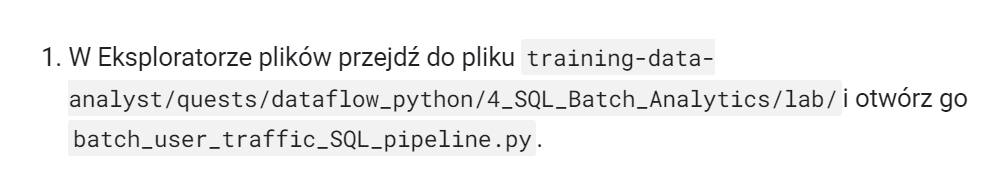

batch_user_traffic_SQL_pipeline.py

In [ ]:
import argparse
import time
import logging
import json
import typing
import apache_beam as beam
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import StandardOptions
from apache_beam.transforms.sql import SqlTransform
from apache_beam.runners import DataflowRunner, DirectRunner

# ### functions and classes

class CommonLog (typing.NamedTuple):
    ip: str
    user_id: str
    lat: float
    lng: float
    timestamp: str
    http_request: str
    http_response: int
    num_bytes: int
    user_agent: str

beam.coders.registry.register_coder(CommonLog, beam.coders.RowCoder)

def parse_json(element):
    row = json.loads(element)
    return CommonLog(**row)

# ### main

def run():
    # Command line arguments
    parser = argparse.ArgumentParser(description='Load from Json into BigQuery')
    parser.add_argument('--project',required=True, help='Specify Google Cloud project')
    parser.add_argument('--region', required=True, help='Specify Google Cloud region')
    parser.add_argument('--staging_location', required=True, help='Specify Cloud Storage bucket for staging')
    parser.add_argument('--temp_location', required=True, help='Specify Cloud Storage bucket for temp')
    parser.add_argument('--runner', required=True, help='Specify Apache Beam Runner')
    parser.add_argument('--input_path', required=True, help='Path to events.json')
    parser.add_argument('--raw_table_name', required=True, help='BigQuery table for raw data')
    parser.add_argument('--agg_table_name', required=True, help='BigQuery table for aggregated data')

    opts, pipeline_opts = parser.parse_known_args()

    # Setting up the Beam pipeline options
    options = PipelineOptions(pipeline_opts, save_main_session=True)
    options.view_as(GoogleCloudOptions).project = opts.project
    options.view_as(GoogleCloudOptions).region = opts.region
    options.view_as(GoogleCloudOptions).staging_location = opts.staging_location
    options.view_as(GoogleCloudOptions).temp_location = opts.temp_location
    options.view_as(GoogleCloudOptions).job_name = '{0}{1}'.format('batch-user-traffic-pipeline-sql-'
                                                                   ,time.time_ns())
    options.view_as(StandardOptions).runner = opts.runner

    input_path = opts.input_path
    agg_table_name = opts.agg_table_name
    raw_table_name = opts.raw_table_name

    # Table schema for BigQuery
    raw_table_schema = {
            "fields": [
                {
                    "name": "ip",
                    "type": "STRING"
                },
                {
                    "name": "user_id",
                    "type": "STRING"
                },
                {
                    "name": "lat",
                    "type": "FLOAT"
                },
                {
                    "name": "lng",
                    "type": "FLOAT"
                },
                {
                    "name": "timestamp",
                    "type": "STRING"
                },
                {
                    "name": "http_request",
                    "type": "STRING"
                },
                {
                    "name": "http_response",
                    "type": "INTEGER"
                },
                {
                    "name": "num_bytes",
                    "type": "INTEGER"
                },
                {
                    "name": "user_agent",
                    "type": "STRING"
                }
            ]
        }


    # Table schema for BigQuery
    agg_table_schema = {
        "fields": [

            {
                "name": "user_id",
                "type": "STRING"
            },
            {
                "name": "page_views",
                "type": "INTEGER"
            },
            {
                "name": "total_bytes",
                "type": "INTEGER"
            },
            {
                "name": "max_bytes",
                "type": "INTEGER"
            },
            {
                "name": "min_bytes",
                "type": "INTEGER"
            },
        ]
    }

    query = """
        SELECT user_id,
        COUNT(*) AS page_views, SUM(num_bytes) as total_bytes,
        MAX(num_bytes) AS max_bytes, MIN(num_bytes) as min_bytes
        FROM PCOLLECTION
        GROUP BY user_id
        """

    # Create the pipeline
    p = beam.Pipeline(options=options)

    logs = (p | 'ReadFromGCS' >> beam.io.ReadFromText(input_path)
              | 'ParseJson' >> beam.Map(parse_json).with_output_types(CommonLog))

    (logs | 'RawToDict' >> beam.Map(lambda row : row._asdict())
          | 'WriteRawToBQ' >> beam.io.WriteToBigQuery(
           raw_table_name,
           schema=raw_table_schema,
           create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
           write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE
      ))

    (logs | 'PerUserAggregations' >> SqlTransform(query, dialect='zetasql')
          | 'AggToDict' >> beam.Map(lambda row : row._asdict())
          | 'WriteAggToBQ' >> beam.io.WriteToBigQuery(
            agg_table_name,
            schema=agg_table_schema,
            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
            write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE
            )
    )

    logging.getLogger().setLevel(logging.INFO)
    logging.info("Building pipeline ...")

    p.run()

if __name__ == '__main__':
  run()


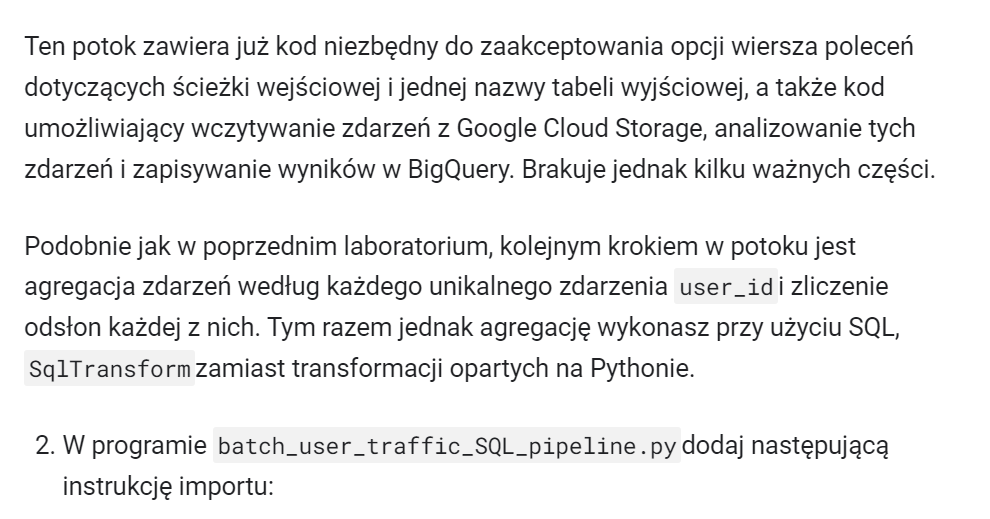

In [ ]:
from apache_beam.transforms.sql import SqlTransform

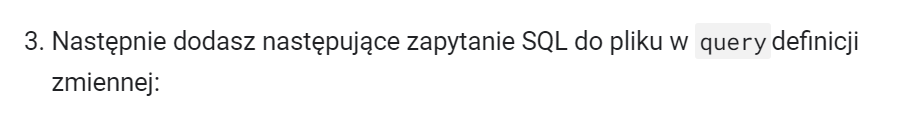

In [ ]:
%%bigquery

SELECT user_id,
COUNT(*) AS page_views, SUM(num_bytes) as total_bytes,
MAX(num_bytes) AS max_bytes, MIN(num_bytes) as min_bytes
FROM PCOLLECTION
GROUP BY user_id

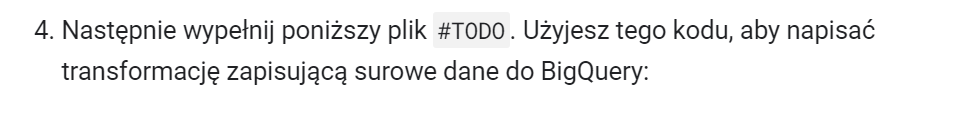

In [ ]:
%%bigquery

logs | 'WriteRawToBQ' >> beam.io.WriteToBigQuery(
  raw_table_name,
  schema=raw_table_schema,
  create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
  write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE
  )

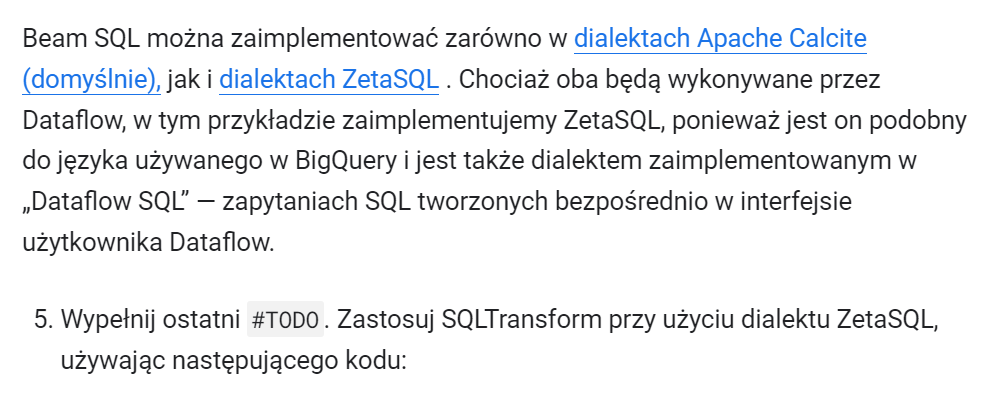

https://beam.apache.org/documentation/dsls/sql/calcite/overview/

https://beam.apache.org/documentation/dsls/sql/zetasql/overview/

In [ ]:
SqlTransform(query, dialect='zetasql')

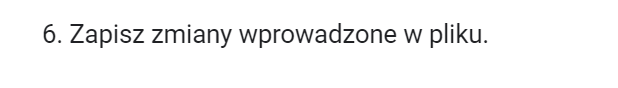

##Zadanie 3. Uruchom potok

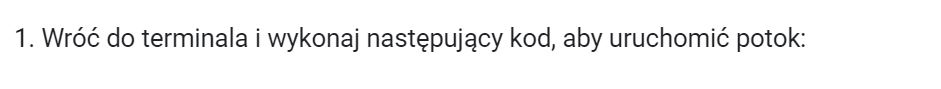

In [ ]:
export PROJECT_ID=$(gcloud config get-value project)
export REGION=us-central1
export BUCKET=gs://${PROJECT_ID}
export PIPELINE_FOLDER=${BUCKET}
export RUNNER=DataflowRunner
export INPUT_PATH=${PIPELINE_FOLDER}/events.json
export TABLE_NAME=${PROJECT_ID}:logs.user_traffic
export AGGREGATE_TABLE_NAME=${PROJECT_ID}:logs.user_traffic
export RAW_TABLE_NAME=${PROJECT_ID}:logs.raw
python3 batch_user_traffic_SQL_pipeline.py \
--project=${PROJECT_ID} \
--region=${REGION} \
--staging_location=${PIPELINE_FOLDER}/staging \
--temp_location=${PIPELINE_FOLDER}/temp \
--runner=${RUNNER} \
--experiments=use_runner_v2 \
--input_path=${INPUT_PATH} \
--agg_table_name=${AGGREGATE_TABLE_NAME} \
--raw_table_name=${RAW_TABLE_NAME}

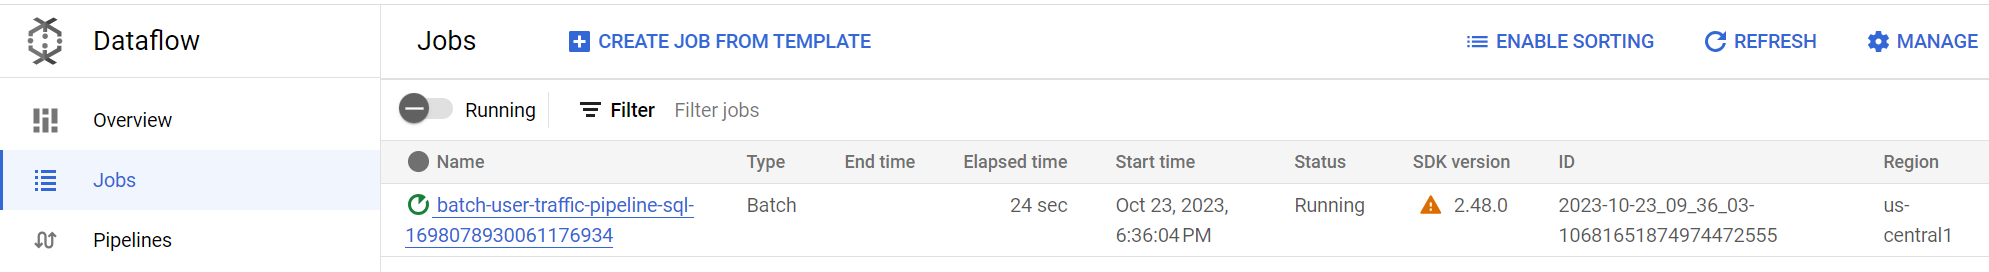

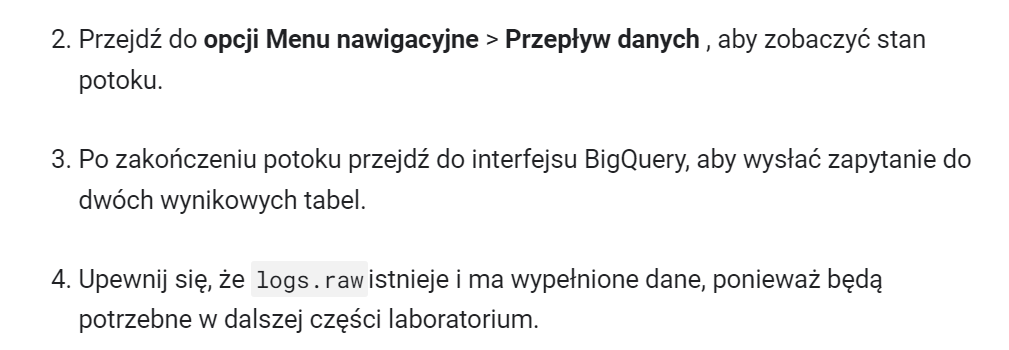

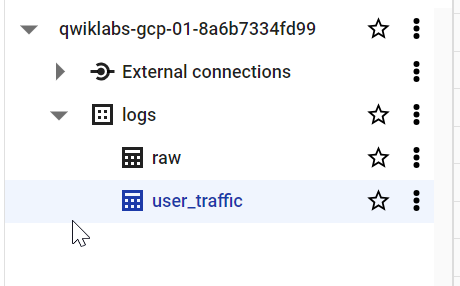

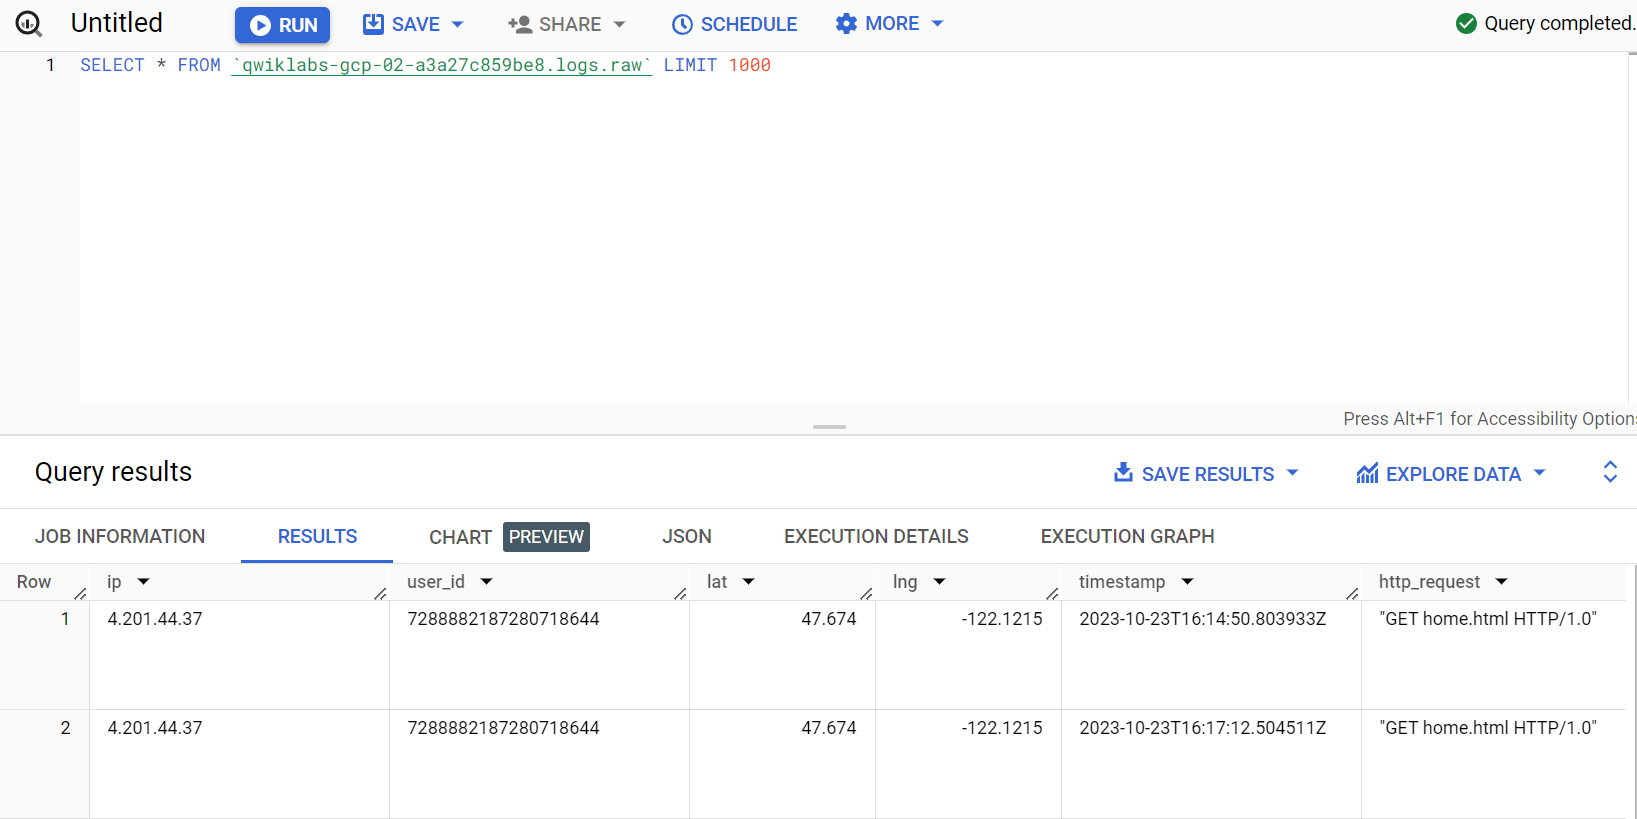

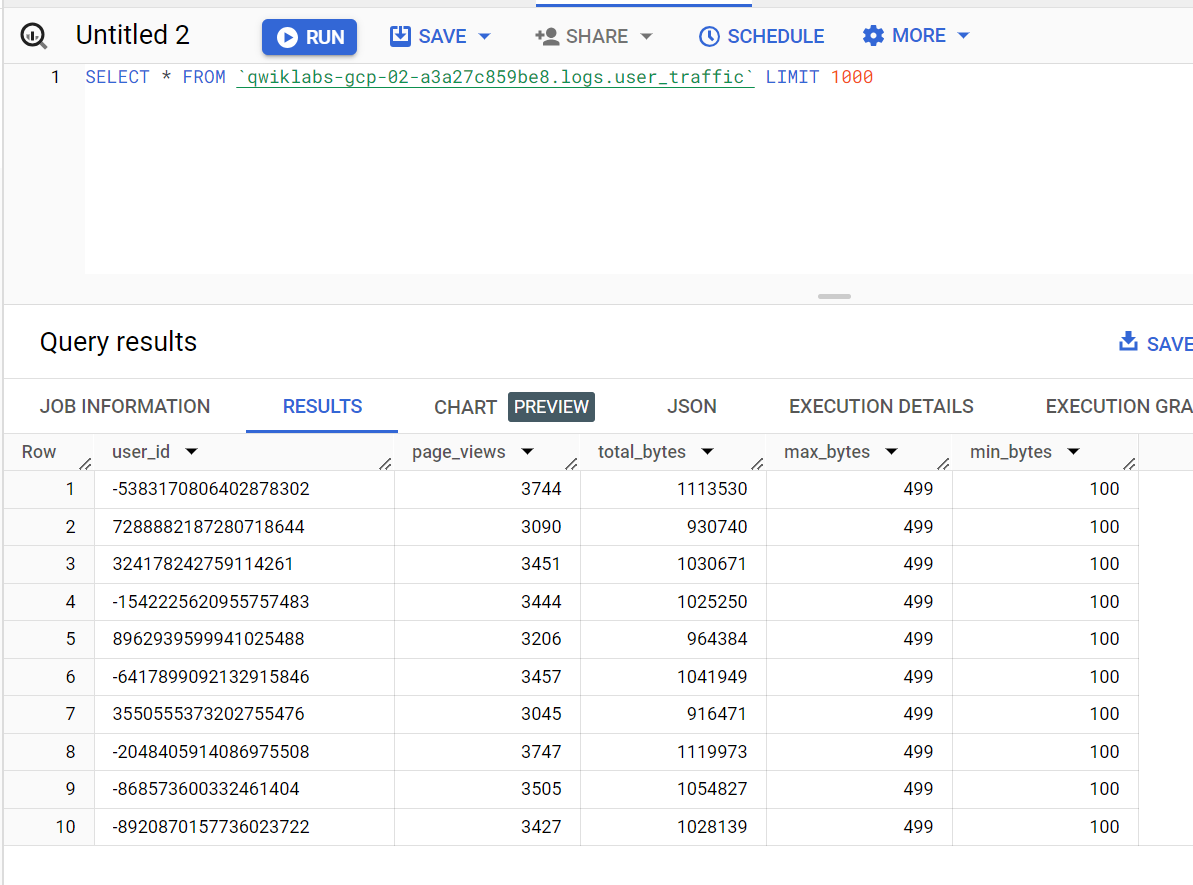

#Część 2: Agregowanie ruchu w witrynie według minut za pomocą SQL

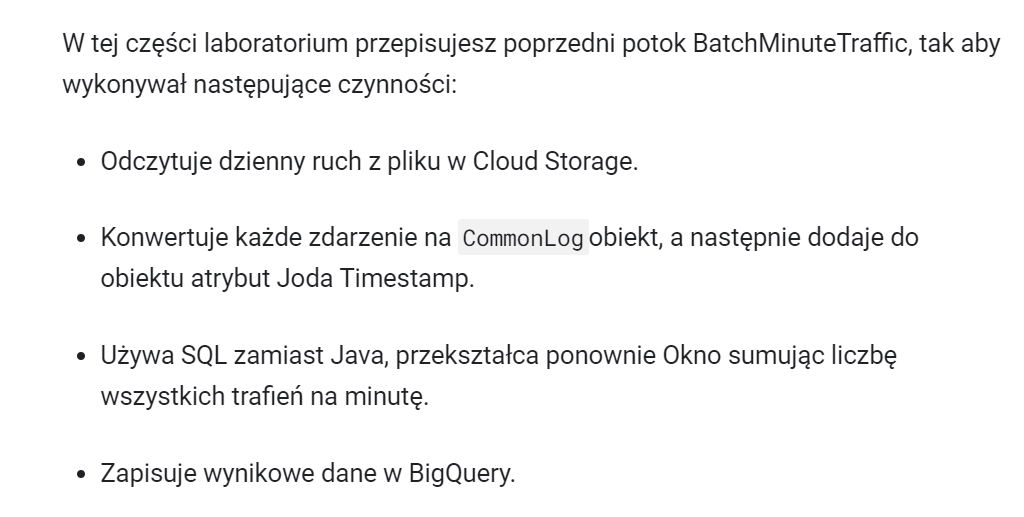

##Zadanie 1. Dodaj pole znacznika czasu do wiersza CommonLog

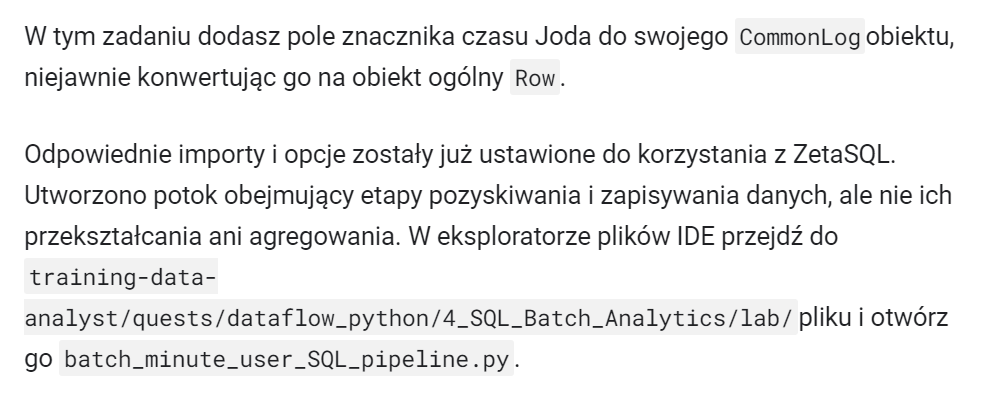

batch_minute_traffic_SQL_pipeline.py

In [ ]:
import argparse
import time
import logging
import json
import typing
from datetime import datetime
import apache_beam as beam
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import StandardOptions
from apache_beam.transforms.sql import SqlTransform
from apache_beam.runners import DataflowRunner, DirectRunner

# ### functions and classes

class CommonLog(typing.NamedTuple):
    ip: str
    user_id: str
    lat: float
    lng: float
    ts: str
    http_request: str
    http_response: int
    num_bytes: int
    user_agent: str

beam.coders.registry.register_coder(CommonLog, beam.coders.RowCoder)

def parse_json(element):
    row = json.loads(element)
    row['ts'] = row['timestamp']
    row.pop('timestamp')
    return CommonLog(**row)

def format_timestamp(element):
    ts = datetime.strptime(element.ts[:-8], "%Y-%m-%dT%H:%M:%S")
    ts = datetime.strftime(ts, "%Y-%m-%d %H:%M:%S")
    temp_dict = element._asdict()
    temp_dict['ts'] = ts
    return CommonLog(**temp_dict)

def to_dict(row):
    return {'page_views' : row.page_views,
            'start_time' : row.start_time}

# ### main

def run():
    # Command line arguments
    parser = argparse.ArgumentParser(description='Load from Json into BigQuery')
    parser.add_argument('--project',required=True, help='Specify Google Cloud project')
    parser.add_argument('--region', required=True, help='Specify Google Cloud region')
    parser.add_argument('--stagingLocation', required=True, help='Specify Cloud Storage bucket for staging')
    parser.add_argument('--tempLocation', required=True, help='Specify Cloud Storage bucket for temp')
    parser.add_argument('--runner', required=True, help='Specify Apache Beam Runner')
    parser.add_argument('--inputPath', required=True, help='Path to events.json')
    parser.add_argument('--tableName', required=True, help='BigQuery table name')

    opts, pipeline_opts = parser.parse_known_args()

    # Setting up the Beam pipeline options
    options = PipelineOptions(pipeline_opts, save_main_session=True)
    options.view_as(GoogleCloudOptions).project = opts.project
    options.view_as(GoogleCloudOptions).region = opts.region
    options.view_as(GoogleCloudOptions).staging_location = opts.stagingLocation
    options.view_as(GoogleCloudOptions).temp_location = opts.tempLocation
    options.view_as(GoogleCloudOptions).job_name = '{0}{1}'.format('batch-minute-traffic-pipeline-sql'
                                                                   ,time.time_ns())
    options.view_as(StandardOptions).runner = opts.runner

    input_path = opts.inputPath
    table_name = opts.tableName

    # Table schema for BigQuery
    table_schema = {
        "fields": [
            {
                "name": "page_views",
                "type": "INTEGER"
            },
            {
                "name": "start_time",
                "type": "STRING"
            },

        ]
    }

    query = '''
        SELECT
            COUNT(*) AS page_views,
            STRING(window_start) AS start_time
        FROM
            TUMBLE(
                (SELECT TIMESTAMP(ts) AS ts FROM PCOLLECTION),
                DESCRIPTOR(ts),
                'INTERVAL 1 MINUTE')
        GROUP BY window_start
    '''

    # Create the pipeline
    p = beam.Pipeline(options=options)

    (p | 'ReadFromGCS' >> beam.io.ReadFromText(input_path)
       | 'ParseJson' >> beam.Map(parse_json).with_output_types(CommonLog)
       | 'FormatTimestamp' >> beam.Map(format_timestamp).with_output_types(CommonLog)
       | "CountPerMinute" >> SqlTransform(query, dialect='zetasql')
       | "ConvertToDict" >> beam.Map(to_dict)
       | 'WriteToBQ' >> beam.io.WriteToBigQuery(
            table_name,
            schema=table_schema,
            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
            write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE
            )
    )

    logging.getLogger().setLevel(logging.INFO)
    logging.info("Building pipeline ...")

    p.run()

if __name__ == '__main__':
  run()


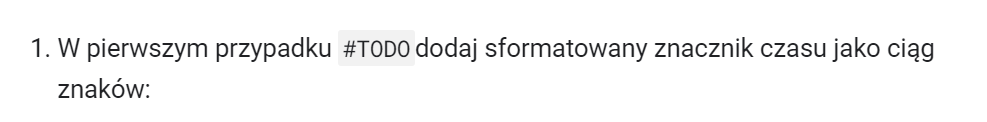

In [ ]:
ts = datetime.strptime(element.ts[:-8], "%Y-%m-%dT%H:%M:%S")
ts = datetime.strftime(ts, "%Y-%m-%d %H:%M:%S")

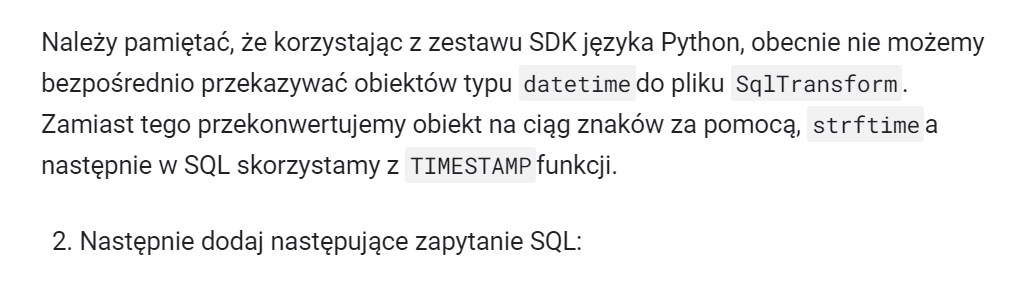

In [ ]:
%%bigquery

SELECT
    COUNT(*) AS page_views,
    STRING(window_start) AS start_time
FROM
    TUMBLE(
        (SELECT TIMESTAMP(ts) AS ts FROM PCOLLECTION),
        DESCRIPTOR(ts),
        'INTERVAL 1 MINUTE')
GROUP BY window_start

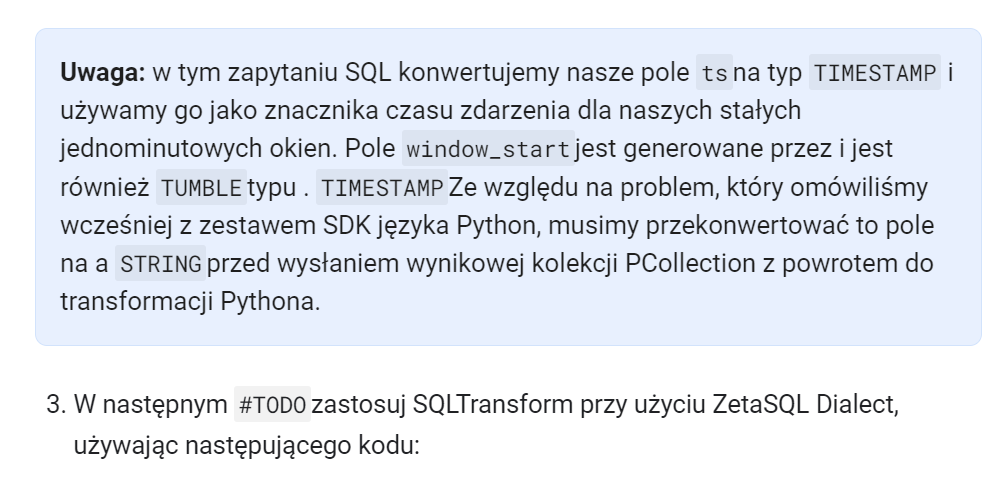

In [ ]:
SqlTransform(query, dialect='zetasql')

##Zadanie 2. Uruchom potok

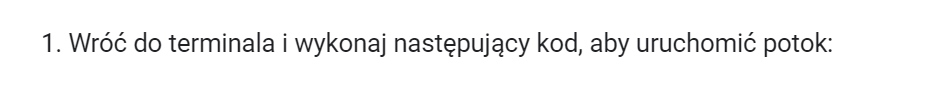

In [ ]:
export PROJECT_ID=$(gcloud config get-value project)
export REGION=us-central1
export BUCKET=gs://${PROJECT_ID}
export PIPELINE_FOLDER=${BUCKET}
export RUNNER=DataflowRunner
export INPUT_PATH=${PIPELINE_FOLDER}/events.json
export TABLE_NAME=${PROJECT_ID}:logs.minute_traffic
python3 batch_minute_traffic_SQL_pipeline.py \
--project=${PROJECT_ID} \
--region=us-central1 \
--stagingLocation=${PIPELINE_FOLDER}/staging \
--tempLocation=${PIPELINE_FOLDER}/temp \
--runner=${RUNNER} \
--inputPath=${INPUT_PATH} \
--tableName=${TABLE_NAME} \
--experiments=use_runner_v2

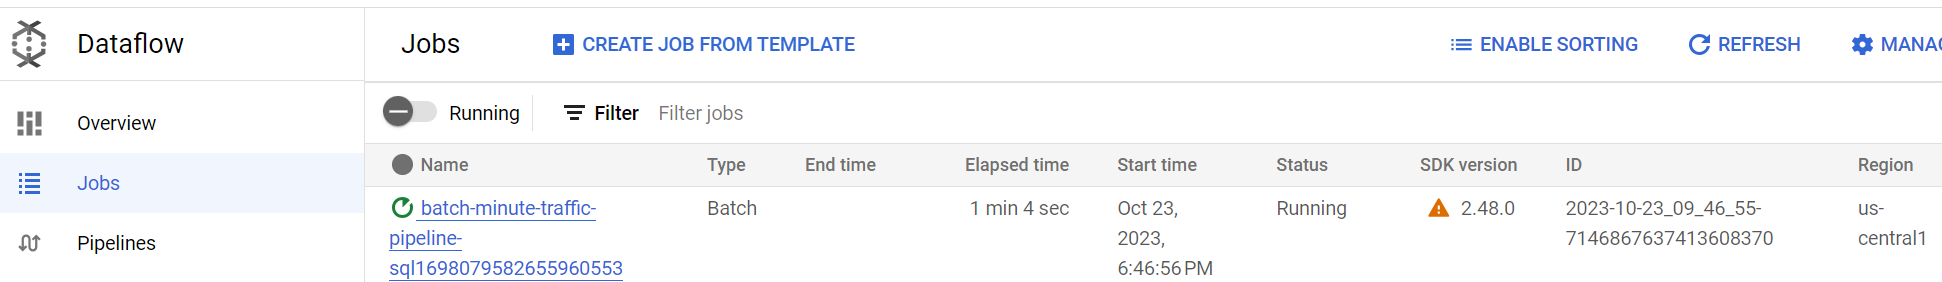

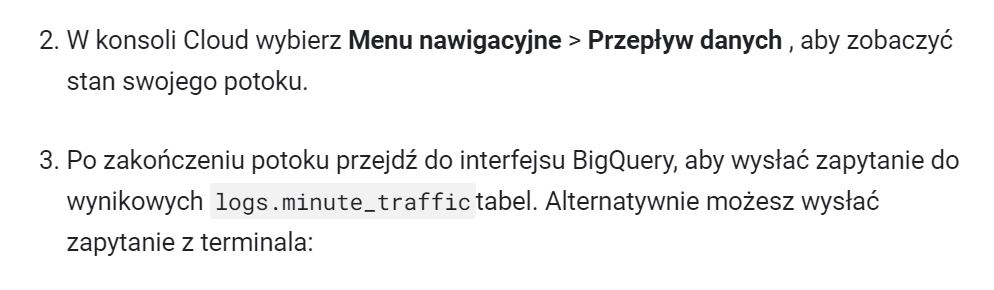

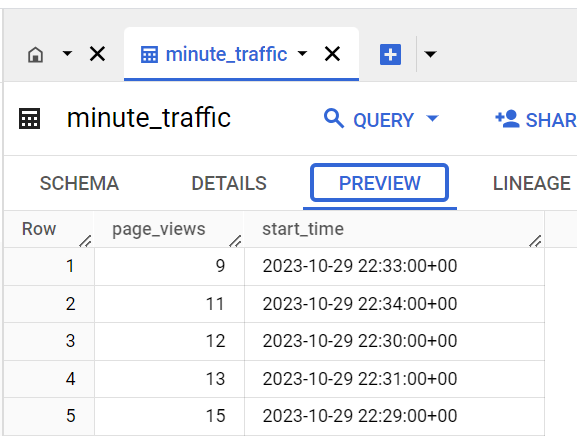

In [ ]:
bq head -n 10 $PROJECT_ID:logs.minute_traffic

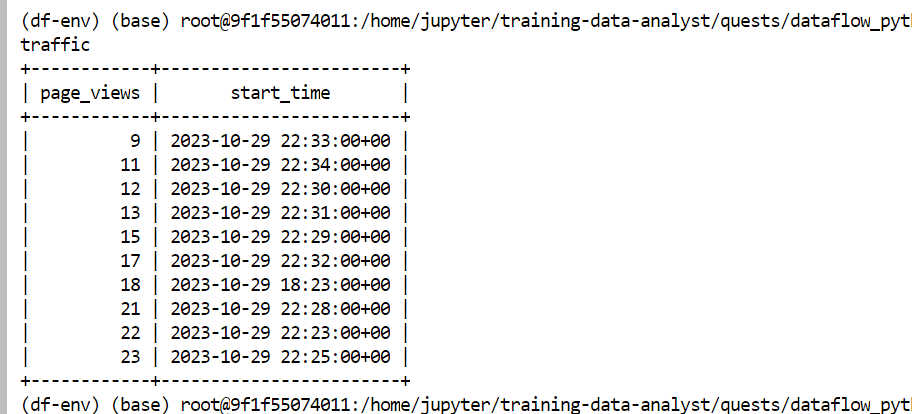